作业4

1、编程实现斑点检测算法

2、编程SIFT点提取及描述算法

1、编程实现斑点检测算法

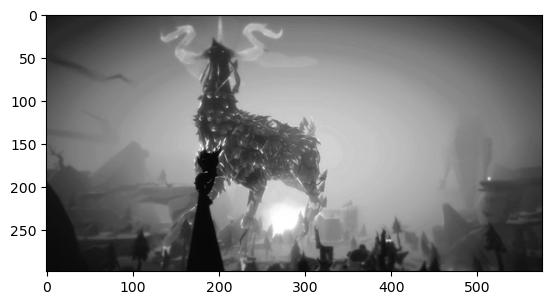

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
 
img = Image.open('image.bmp')#选择自己的图片路径导入
s=np.array(img.convert('L'))
 
plt.imshow(s, cmap='gray')#彩色图转灰度图

In [17]:
def generate_norm_log_filter(sigma):
    size = int(2 * np.ceil(sigma * 2.5) + 1)
    kernel = np.fromfunction(lambda x, y: ((x-size//2)**2 + (y-size//2)**2 - 2*sigma**2) / (sigma**4) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)), (size, size))
    return kernel


def conv2d(input, kernel, bias=0, stride=1, padding=False):
    #input可以是图像经数组化的二维矩阵，kernel为卷积核本身输入，函数应可计算图像尺寸，改写卷积核，偏置，步长和填充。
    input_height, input_width = input.shape
    kernel_height, kernel_width = kernel.shape
    # padding
    if padding:
        padding = kernel_width // 2
        padded_input = np.pad(input, padding, mode='constant')
    else:
        padding = 0
        padded_input = input
    # 计算输出尺寸
    output_height = (input_height - kernel_height + 2 * padding) // stride + 1
    output_width = (input_width - kernel_width + 2 * padding) // stride + 1
    # 创建输出图像数组
    output = np.zeros((output_height, output_width))
    # 卷积
    for y in range(0, output_height):
        for x in range(0, output_width):
            conv_result = np.sum(padded_input[y * stride:y * stride + kernel_height, x * stride:x * stride + kernel_width] * kernel)
            conv_result += bias
            output[y, x] = conv_result
    return output


def drawcircle(img, o, r):
    #补充相关功能
    thickness = 1
    h, w = img.shape
    ox, oy = o
    for i in range(h):
        for j in range(w):
            d = math.hypot(i - oy, j - ox)
            if r >= d >= r-thickness:
                s[i][j] = 255

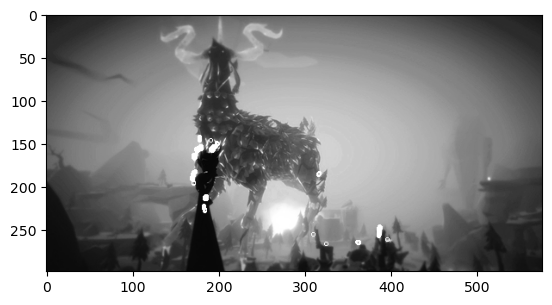

In [18]:
# 生成LOG滤波器
sigma = 2.0
log_filter = generate_norm_log_filter(sigma)

filtered_image = conv2d(s, log_filter)

# 对卷积结果进行阈值处理来检测斑点
threshold = 0.5
spots = np.where(filtered_image > threshold * filtered_image.max())
spots = np.column_stack((spots[1], spots[0]))

r = sigma * 1.414
# 绘制检测到的斑点
for spot in spots:
    drawcircle(s, spot, r)

plt.imshow(s, cmap='gray')

2、编程SIFT点提取及描述算法

In [19]:
def compute_gradients(image):
    kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32)
    kernel_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=np.float32)

    gradient_x = convolve(image, kernel_x)
    gradient_y = convolve(image, kernel_y)

    return gradient_x, gradient_y

def convolve(image, kernel):
    kernel_height, kernel_width = kernel.shape
    image_height, image_width = image.shape

    padding_height = kernel_height // 2
    padding_width = kernel_width // 2

    padded_image = np.pad(image, ((padding_height, padding_height), (padding_width, padding_width)), mode='constant')

    output = np.zeros_like(image)

    for y in range(image_height):
        for x in range(image_width):
            patch = padded_image[y:y + kernel_height, x:x + kernel_width]
            output[y, x] = np.sum(patch * kernel)

    return output

def compute_magnitude_and_angle(gradient_x, gradient_y):
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    angle = np.arctan2(gradient_y, gradient_x)

    return magnitude, angle

def detect_keypoints(magnitude):
    keypoints = []

    image_height, image_width = magnitude.shape

    for y in range(1, image_height - 1):
        for x in range(1, image_width - 1):
            patch = magnitude[y-1:y+2, x-1:x+2]
            center_value = patch[1, 1]
            if center_value > np.max(patch) or center_value < np.min(patch):
                keypoints.append((x, y))

    return keypoints

def compute_descriptors(keypoints, gradient_x, gradient_y, angle):
    descriptors = []

    for keypoint in keypoints:
        x, y = keypoint
        patch = get_patch(gradient_x, gradient_y, angle, x, y)
        descriptor = normalize_descriptor(patch)
        descriptors.append(descriptor)

    return descriptors

def get_patch(gradient_x, gradient_y, angle, x, y):
    patch_size = 16
    patch = np.zeros((patch_size, patch_size))

    half_size = patch_size // 2

    for i in range(patch_size):
        for j in range(patch_size):
            angle_index = int((angle[y - half_size + i, x - half_size + j] + np.pi) * 180 / (2 * np.pi))
            patch[i, j] = gradient_magnitude[y - half_size + i, x - half_size + j] * histogram[angle_index]

    return patch

def normalize_descriptor(descriptor):
    descriptor /= np.linalg.norm(descriptor)
    descriptor[descriptor > 0.2] = 0.2
    descriptor /= np.linalg.norm(descriptor)

    return descriptor

In [20]:
def sift_feature_extraction(image):
    # 计算图像梯度
    gradient_x, gradient_y = compute_gradients(image)

    # 计算梯度幅值和方向
    magnitude, angle = compute_magnitude_and_angle(gradient_x, gradient_y)

    # 获取关键点
    keypoints = detect_keypoints(magnitude)

    # 计算描述符
    descriptors = compute_descriptors(keypoints, gradient_x, gradient_y, angle)

    return keypoints, descriptors

In [21]:
# 读取图像
img = Image.open('image.bmp')#选择自己的图片路径导入
s=np.array(img.convert('L'))
# 提取SIFT特征
keypoints, descriptors = sift_feature_extraction(s)
# 打印关键点和描述符
for i, keypoint in enumerate(keypoints):
    descriptor = descriptors[i]
    print("Keypoint:", keypoint)
    print("Descriptor:", descriptor)